In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
import json
from scipy.stats import shapiro

In [2]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', UserWarning)

In [3]:
with open('config.json') as f:
    config = json.load(f)

data_path = config["data_path"]

ts = pd.read_csv(data_path)
ts = ts["Close"].values

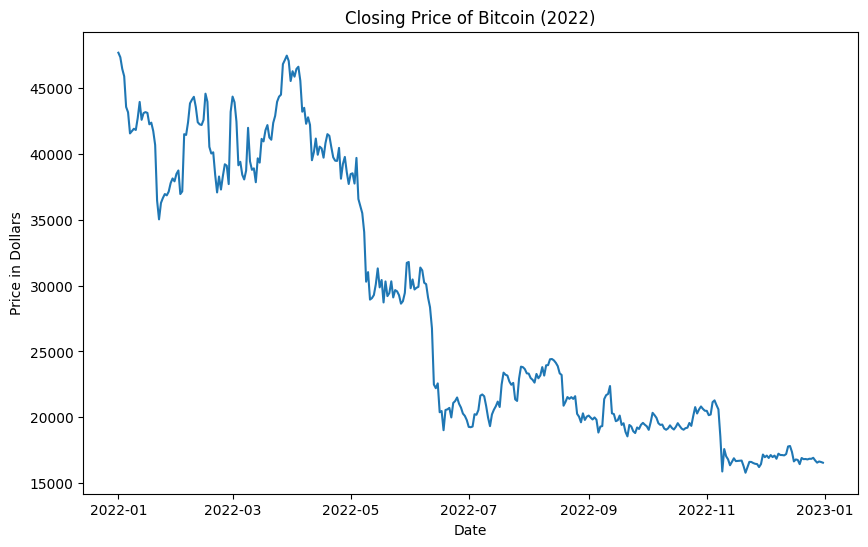

In [4]:
start_date = '2022-01-01'
end_date = '2022-12-31'
date_range = pd.date_range(start=start_date, end=end_date)

plt.figure(figsize=(10, 6))
plt.plot(date_range, ts)
plt.title('Closing Price of Bitcoin (2022)')
plt.xlabel('Date')
plt.ylabel('Price in Dollars')
plt.show()

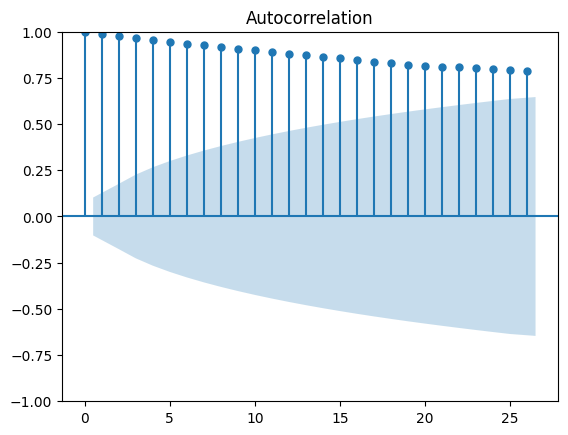

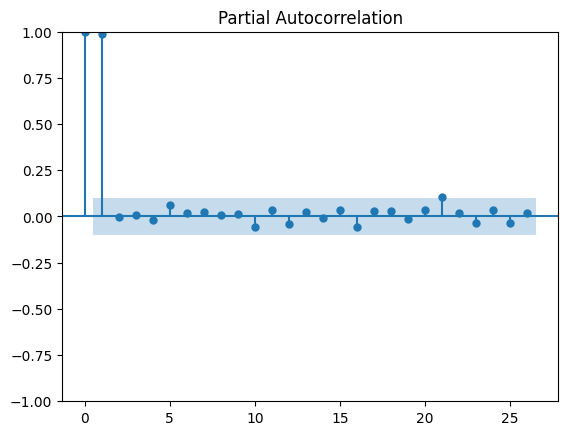

In [5]:
plot_acf(ts)
plt.show()

plot_pacf(ts)
plt.show()

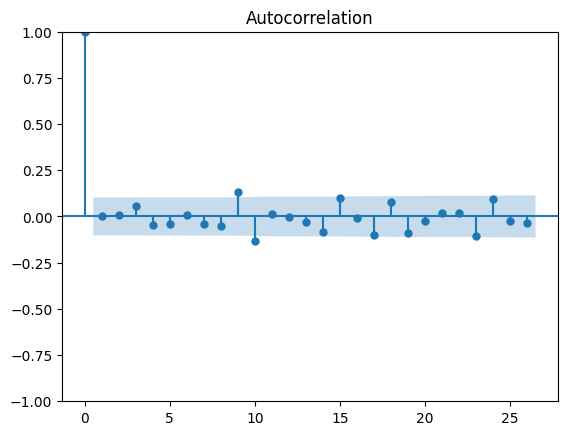

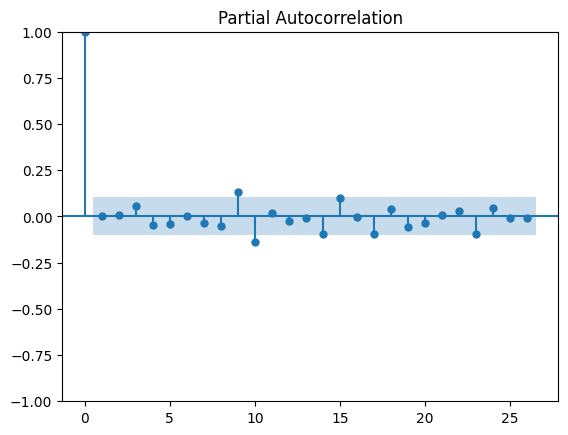

In [6]:
diff = np.diff(ts)

plot_acf(diff)
plt.show()

plot_pacf(diff)
plt.show()

In [7]:
unit_test = adfuller(diff)

#Print results
print('ADF Statistic: %f' % unit_test[0])
print('p-value: %f' % unit_test[1])
print('Critical Values:', unit_test[4])

if unit_test[1] <= 0.05:
    print(f'Reject the null hypothesis. The time-series is stationary.')
else: 
    print(f"Fail to reject the null hypothesis. The time-series is non-stationary")

ADF Statistic: -6.511663
p-value: 0.000000
Critical Values: {'1%': np.float64(-3.4489583388155194), '5%': np.float64(-2.869739378430086), '10%': np.float64(-2.5711381780459)}
Reject the null hypothesis. The time-series is stationary.


In [8]:
# train-validation-test split for time series
train_size = int(len(ts) * 0.70)
train, rest = ts[:train_size], ts[train_size:]

validation_size = int(len(rest) * 0.50)
validation, test = rest[:validation_size], rest[validation_size:]

print(len(train))
print(len(validation))
print(len(test))

255
55
55


In [9]:
lowest_aic = float('inf')
best_p_aic = None
best_q_aic = None

lowest_bic = float('inf')
best_p_bic = None
best_q_bic = None

for p in range(0,10):
    for q in range(0,10):
        #create model
        model=ARIMA(train, order=(p,1,q))
        results = model.fit()

        #AIC and BIC of model
        aic = results.aic
        bic = results.bic
        print(f"AR({p}), MA({q}), AIC: {aic}, BIC: {bic}")

        #Update the best order based on the lowest AIC
        if aic < lowest_aic:
            lowest_aic = aic
            best_p_aic = p
            best_q_aic = q
        
        #Update the best order based on the lowest BIC
        if bic < lowest_bic:
            lowest_bic = bic
            best_p_bic = p
            best_q_bic = q

print(f"\nBest ARIMA order based on AIC: ({best_p_aic},1,{best_q_aic}) \nBest ARIMA order based on BIC: ({best_p_bic},1,{best_q_bic})")

AR(0), MA(0), AIC: 4308.818418459345, BIC: 4312.355752726363
AR(0), MA(1), AIC: 4310.803344628967, BIC: 4317.878013163005
AR(0), MA(2), AIC: 4312.582955478284, BIC: 4323.1949582793395
AR(0), MA(3), AIC: 4314.543914370507, BIC: 4328.693251438581
AR(0), MA(4), AIC: 4312.793480790293, BIC: 4330.480152125386
AR(0), MA(5), AIC: 4314.473800275959, BIC: 4335.69780587807
AR(0), MA(6), AIC: 4315.183458348754, BIC: 4339.944798217884
AR(0), MA(7), AIC: 4317.1841683503335, BIC: 4345.482842486482
AR(0), MA(8), AIC: 4318.819475717366, BIC: 4350.6554841205325
AR(0), MA(9), AIC: 4318.8396647545305, BIC: 4354.213007424716
AR(1), MA(0), AIC: 4310.80356557217, BIC: 4317.878234106207
AR(1), MA(1), AIC: 4312.8100688094255, BIC: 4323.422071610481
AR(1), MA(2), AIC: 4309.671561545709, BIC: 4323.820898613783
AR(1), MA(3), AIC: 4311.428335514823, BIC: 4329.1150068499155
AR(1), MA(4), AIC: 4312.733212391954, BIC: 4333.957217994065
AR(1), MA(5), AIC: 4313.4176956712545, BIC: 4338.179035540385
AR(1), MA(6), AIC: 

In [10]:
model = ARIMA(train, order=(best_p_aic,1,best_q_aic))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  255
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -2147.662
Date:                Tue, 10 Dec 2024   AIC                           4307.325
Time:                        14:51:31   BIC                           4328.549
Sample:                             0   HQIC                          4315.863
                                - 255                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.9230      0.028    -67.783      0.000      -1.979      -1.867
ar.L2         -0.9249      0.028    -32.806      0.000      -0.980      -0.870
ma.L1          1.9554      0.077     25.526      0.0

Residual Diagnostics:

Ljung-Box Test for Autocorrelation:
    lb_stat  lb_pvalue
1  0.224022   0.635992
2  0.376581   0.828374
3  1.088753   0.779790
4  1.284351   0.864025
5  2.035529   0.844207
6  2.075435   0.912632
7  2.998540   0.885137
8  3.884651   0.867378

Shapiro-Wilk Test for Normality:
Statistic: 0.9369, p-value: 0.0000
Residuals are likely not normally distributed (reject H0).


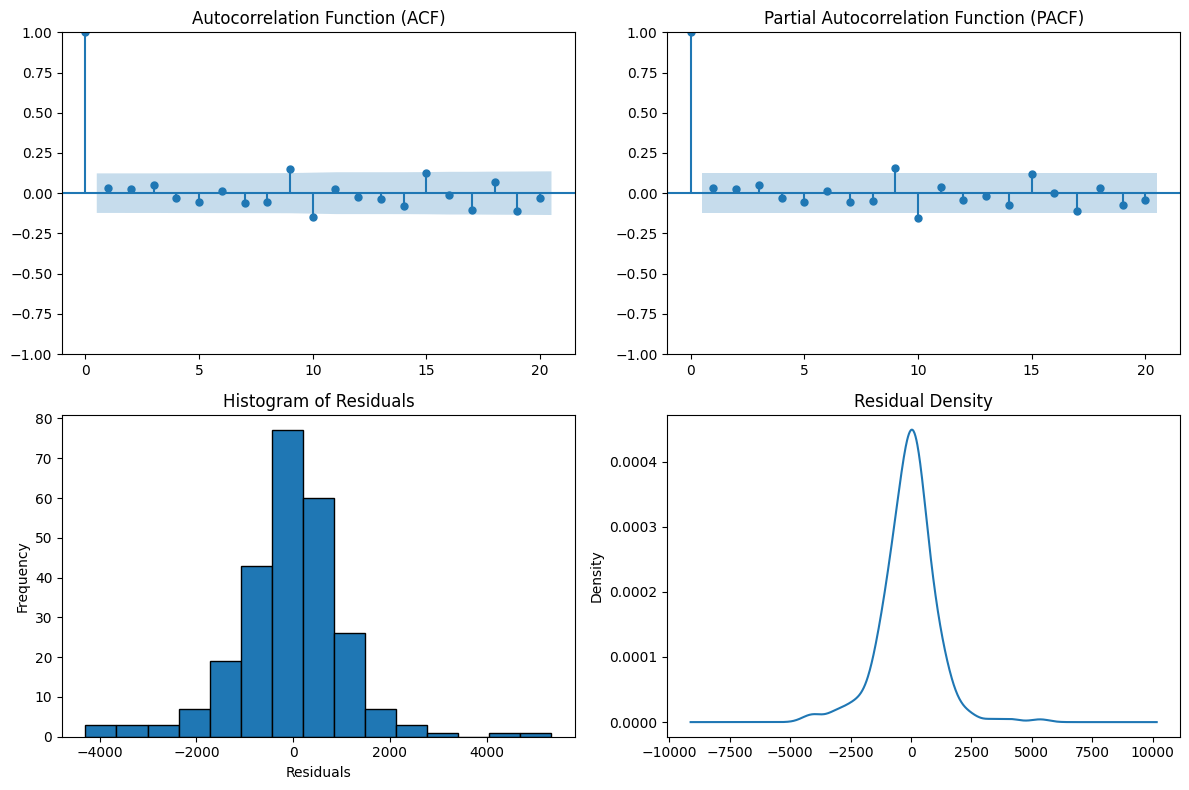

In [11]:
residuals = results.resid[1:]

def residual_diagnostics(residuals):
    print("Residual Diagnostics:\n")
    
    # 1. Test for autocorrelation using Ljung-Box test
    lb_test = acorr_ljungbox(residuals, lags=8, return_df=True)
    print(f"Ljung-Box Test for Autocorrelation:\n{lb_test}")
    
    # 2. Test for normality using Shapiro-Wilk test
    shapiro_stat, shapiro_p = shapiro(residuals)
    print("\nShapiro-Wilk Test for Normality:")
    print(f"Statistic: {shapiro_stat:.4f}, p-value: {shapiro_p:.4f}")
    
    if shapiro_p > 0.05:
        print("Residuals are likely normally distributed (fail to reject H0).")
    else:
        print("Residuals are likely not normally distributed (reject H0).")
    
    # 3. Plot Residual Diagnostics
    plt.figure(figsize=(12, 8))
    
    # Plot ACF
    plt.subplot(2, 2, 1)
    plot_acf(residuals, lags=20, ax=plt.gca())
    plt.title("Autocorrelation Function (ACF)")
    
    # Plot PACF
    plt.subplot(2, 2, 2)
    plot_pacf(residuals, lags=20, ax=plt.gca(), method='ywm')
    plt.title("Partial Autocorrelation Function (PACF)")
    
    # Histogram of residuals
    plt.subplot(2, 2, 3)
    plt.hist(residuals, bins=15, edgecolor='k')
    plt.title("Histogram of Residuals")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    
    # QQ Plot
    plt.subplot(2, 2, 4)
    pd.Series(residuals).plot(kind='kde')
    plt.title("Residual Density")
    
    plt.tight_layout()
    plt.show()

# Perform diagnostics
residual_diagnostics(residuals)

In [12]:
fitted = results.fittedvalues[1:] #remove the first value due to differencing in ARIMA

mse = mean_squared_error(train[1:], fitted)
rmse = sqrt(mse)
print(f"Train RMSE: {rmse}")

Train RMSE: 1137.5035945158836


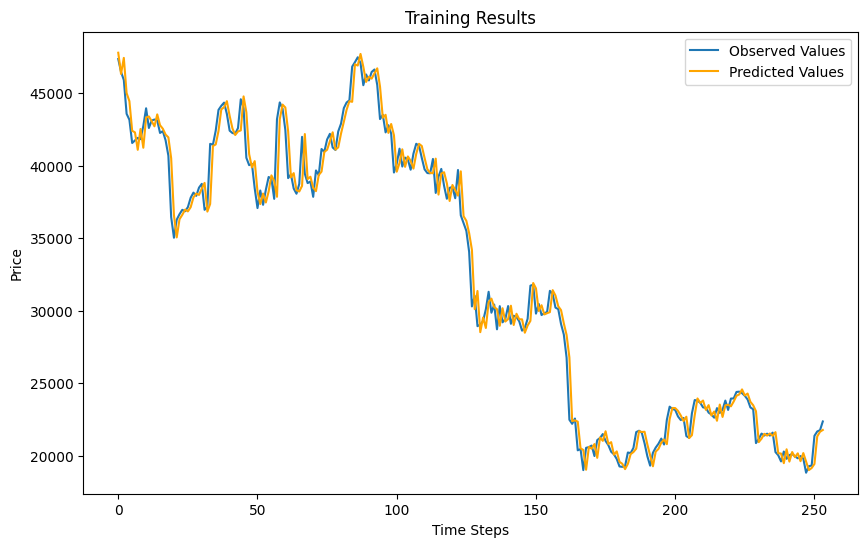

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(train[1:], label='Observed Values')
plt.plot(fitted, c='orange', label="Predicted Values")
plt.title("Training Results")
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()

## Validation

In [14]:
def validiation_process(validation_set):
    '''
    Selects the most optimal model parameters based on RMSE on the validation set. 

    Input: validation set
    Output: optimal p, optimal q, rmse, predictions
    '''

    #These are the values to be returned by this function
    best_p = None
    best_q = None
    lowest_rmse = float('inf')
    predictions = []

    #Run through each possible p and q in our selected range
    for p in range(0,9):
        for q in range(0,9):
            try:
                history = list(validation_set) #reset history
                temp_predictions = [] 

                #Run through each valdiation set observation
                for i in range(len(validation_set+1)):
                    model = ARIMA(history, order=(p,1,q))
                    results = model.fit()
                    
                    #One-step-ahead forecast
                    yhat = results.forecast()
                    yhat = yhat[0]

                    #Append history with latest observation and update predictions with latest prediction
                    obs = validation_set[i]
                    history.append(obs)
                    temp_predictions.append(yhat)
                    # predictions[f'ARIMA({p},1,{q}) Predictions'].append(yhat)

                #Calculate RMSE for the predictions 
                valid_mse = mean_squared_error(validation_set, temp_predictions)
                valid_rmse = sqrt(valid_mse)
                print(f"Validation RMSE for ARIMA({p},1,{q}): {valid_rmse}")

                #Update optimal ARMA model based on RMSE and update its predictions
                if valid_rmse < lowest_rmse:
                    best_p = p
                    best_q = q
                    lowest_rmse = valid_rmse
                    predictions = temp_predictions
                    print(f"New best p and q: {best_p}, {best_q}")

            except Exception as e:
                print(f'Skipped ARIMA({p},1,{q}) due to: {e}')
            
    return best_p, best_q, lowest_rmse, predictions

best_p_valid, best_q_valid, lowest_rmse_valid, valid_predictions = validiation_process(validation)

Validation RMSE for ARIMA(0,1,0): 369.7800391946432
New best p and q: 0, 0
Validation RMSE for ARIMA(0,1,1): 372.6861716353391
Validation RMSE for ARIMA(0,1,2): 359.5319158502264
New best p and q: 0, 2
Validation RMSE for ARIMA(0,1,3): 361.1234086865088
Validation RMSE for ARIMA(0,1,4): 361.609392797465
Validation RMSE for ARIMA(0,1,5): 375.9936104307678
Validation RMSE for ARIMA(0,1,6): 379.11434429681
Validation RMSE for ARIMA(0,1,7): 384.0862951894135
Validation RMSE for ARIMA(0,1,8): 372.26012531770397
Validation RMSE for ARIMA(1,1,0): 371.3498039168105
Validation RMSE for ARIMA(1,1,1): 366.8822758227079
Validation RMSE for ARIMA(1,1,2): 363.61268088285243
Validation RMSE for ARIMA(1,1,3): 358.9051773914312
New best p and q: 1, 3
Validation RMSE for ARIMA(1,1,4): 364.05496683420716
Validation RMSE for ARIMA(1,1,5): 377.07762074685894
Validation RMSE for ARIMA(1,1,6): 378.4172240029089
Validation RMSE for ARIMA(1,1,7): 377.4709883560426
Validation RMSE for ARIMA(1,1,8): 372.38096748

Optimal ARIMA Model: ARIMA(6,1,2)
Validation RMSE: 356.0083987822205


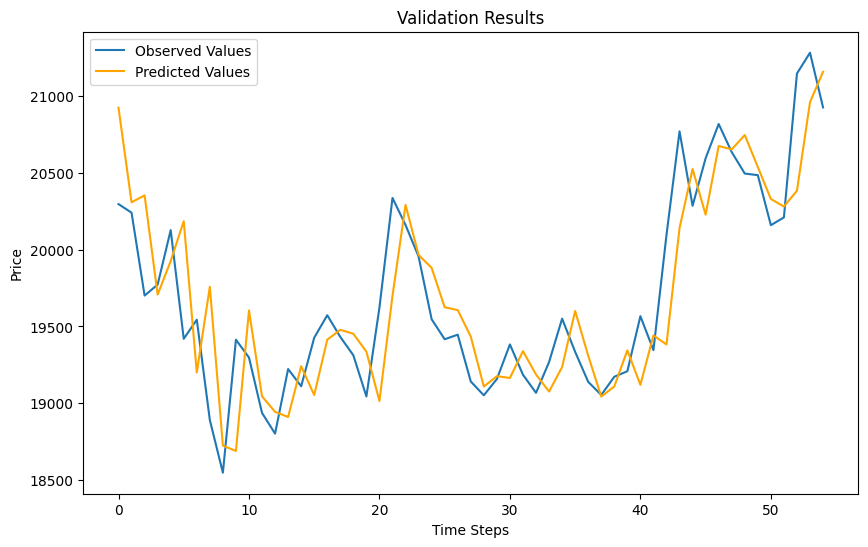

In [15]:
print(f'Optimal ARIMA Model: ARIMA({best_p_valid},1,{best_q_valid})')
print(f'Validation RMSE: {lowest_rmse_valid}')

plt.figure(figsize=(10, 6))
plt.plot(validation, label='Observed Values')
plt.plot(valid_predictions, c='orange', label="Predicted Values")
plt.title("Validation Results")
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()

Residual Diagnostics:

Ljung-Box Test for Autocorrelation:
    lb_stat  lb_pvalue
1  0.224022   0.635992
2  0.376581   0.828374
3  1.088753   0.779790
4  1.284351   0.864025
5  2.035529   0.844207
6  2.075435   0.912632
7  2.998540   0.885137
8  3.884651   0.867378

Shapiro-Wilk Test for Normality:
Statistic: 0.9369, p-value: 0.0000
Residuals are likely not normally distributed (reject H0).


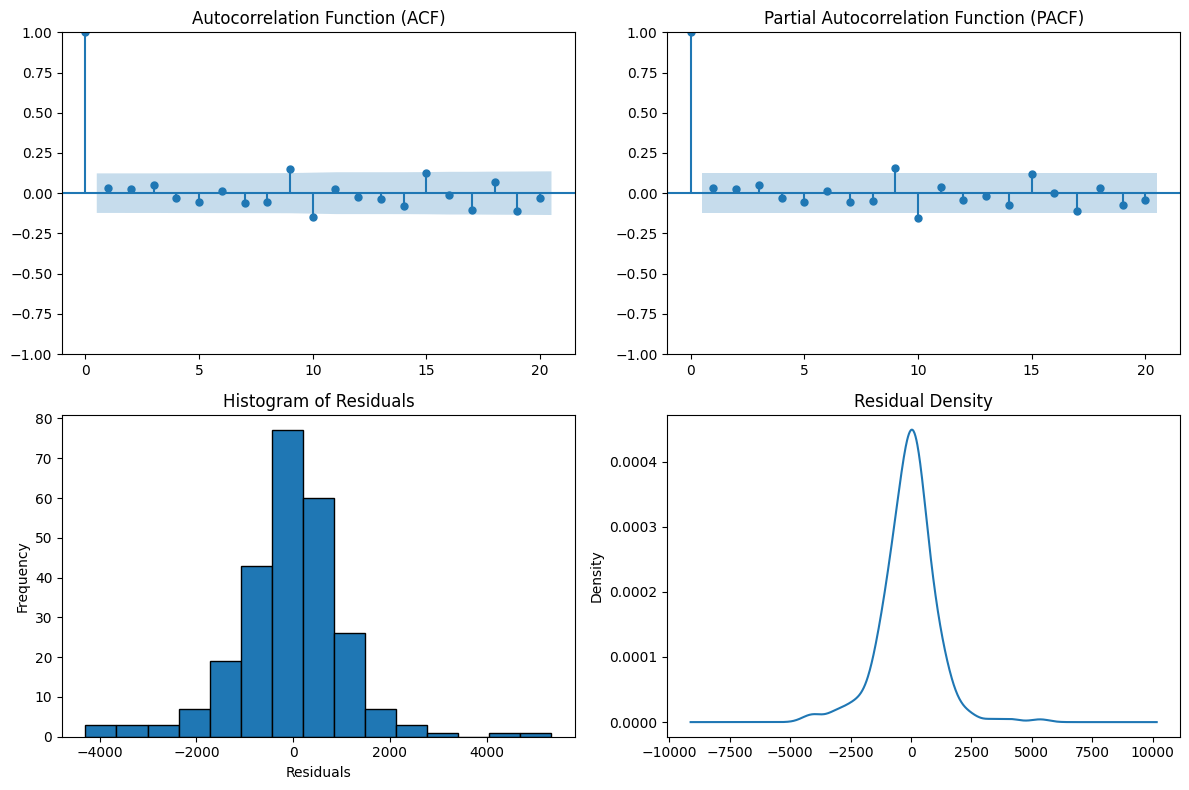

In [16]:
# plot residuals
residuals_valid = validation - valid_predictions
residual_diagnostics(residuals)
